In [1]:
# Notebook 2: Prétraitement des données - Tunisie complète

import pandas as pd
import numpy as np
import json
import geopandas as gpd
from geopy.distance import geodesic
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

print("=== PRÉTRAITEMENT DES DONNÉES - ML-TuniMapAi (TUNISIE COMPLÈTE) ===")
print()

=== PRÉTRAITEMENT DES DONNÉES - ML-TuniMapAi (TUNISIE COMPLÈTE) ===



In [2]:
# 1. CHARGEMENT DES DONNÉES PRÉPROCESSÉES
print("1. CHARGEMENT DES DONNÉES PRÉTRAITÉES")
print("-" * 60)

# Chargement des données principales
delegations_df = pd.read_csv('../data/processed/tunisia_delegations.csv')
governorates_df = pd.read_csv('../data/processed/governorates_summary.csv')

print(f"Données chargées:")
print(f"- Délégations: {len(delegations_df)}")
print(f"- Gouvernorats: {len(governorates_df)}")
print(f"- Colonnes délégations: {list(delegations_df.columns)}")
print()

1. CHARGEMENT DES DONNÉES PRÉTRAITÉES
------------------------------------------------------------
Données chargées:
- Délégations: 4788
- Gouvernorats: 24
- Colonnes délégations: ['Name', 'NameAr', 'Value', 'PostalCode', 'Latitude', 'Longitude', 'Governorate', 'GovernorateAr', 'GovernorateValue']



In [3]:
# 2. NETTOYAGE ET STANDARDISATION AVANCÉS
print("2. NETTOYAGE ET STANDARDISATION AVANCÉS")
print("-" * 60)

# Vérification des valeurs manquantes
missing_values = delegations_df.isnull().sum()
print("Valeurs manquantes:")
print(missing_values[missing_values > 0])

# Nettoyage des données textuelles
delegations_df['Name'] = delegations_df['Name'].str.strip()
delegations_df['NameAr'] = delegations_df['NameAr'].str.strip() 
delegations_df['Governorate'] = delegations_df['Governorate'].str.strip()

# Correction des coordonnées aberrantes (si nécessaire)
# Limites géographiques de la Tunisie
TUNISIA_BOUNDS = {
    'lat_min': 30.0, 'lat_max': 38.0,
    'lon_min': 7.0, 'lon_max': 12.0
}

# Filtrage des coordonnées aberrantes
valid_coords = (
    (delegations_df['Latitude'] >= TUNISIA_BOUNDS['lat_min']) &
    (delegations_df['Latitude'] <= TUNISIA_BOUNDS['lat_max']) &
    (delegations_df['Longitude'] >= TUNISIA_BOUNDS['lon_min']) &
    (delegations_df['Longitude'] <= TUNISIA_BOUNDS['lon_max'])
)

print(f"Points avec coordonnées valides: {valid_coords.sum()}/{len(delegations_df)}")
delegations_df = delegations_df[valid_coords].copy()

# Création d'identifiants uniques
delegations_df['zone_id'] = range(1, len(delegations_df) + 1)
delegations_df['unique_id'] = delegations_df['Governorate'].str.upper() + '_' + delegations_df['zone_id'].astype(str)

print(f"Dataset nettoyé: {len(delegations_df)} points valides")
print()

2. NETTOYAGE ET STANDARDISATION AVANCÉS
------------------------------------------------------------
Valeurs manquantes:
Series([], dtype: int64)
Points avec coordonnées valides: 4788/4788
Dataset nettoyé: 4788 points valides



In [4]:
# 3. ENRICHISSEMENT DES DONNÉES GÉOGRAPHIQUES
print("3. ENRICHISSEMENT DES DONNÉES GÉOGRAPHIQUES")
print("-" * 60)

# Calcul des centres régionaux
def calculate_regional_centers(df):
    """Calcule les centres géographiques par région"""
    regional_centers = df.groupby('Governorate').agg({
        'Latitude': 'mean',
        'Longitude': 'mean',
        'zone_id': 'count'
    }).rename(columns={'zone_id': 'zone_count'})
    
    return regional_centers

regional_centers = calculate_regional_centers(delegations_df)
print("Centres régionaux calculés:")
print(regional_centers.head())

# Ajout des distances aux centres régionaux et national
tunisia_center = (delegations_df['Latitude'].mean(), delegations_df['Longitude'].mean())
print(f"\nCentre national de la Tunisie: {tunisia_center}")

def add_distance_features(df):
    """Ajoute les features de distance"""
    df = df.copy()
    
    # Distance au centre national
    df['distance_to_national_center'] = df.apply(
        lambda row: geodesic((row['Latitude'], row['Longitude']), tunisia_center).kilometers,
        axis=1
    )
    
    # Distance au centre régional
    distances_to_regional = []
    for _, row in df.iterrows():
        regional_center = regional_centers.loc[row['Governorate']]
        dist = geodesic(
            (row['Latitude'], row['Longitude']),
            (regional_center['Latitude'], regional_center['Longitude'])
        ).kilometers
        distances_to_regional.append(dist)
    
    df['distance_to_regional_center'] = distances_to_regional
    
    return df

delegations_df = add_distance_features(delegations_df)

print(f"Features de distance ajoutées")
print(f"Distance moyenne au centre national: {delegations_df['distance_to_national_center'].mean():.2f} km")
print(f"Distance moyenne au centre régional: {delegations_df['distance_to_regional_center'].mean():.2f} km")
print()

3. ENRICHISSEMENT DES DONNÉES GÉOGRAPHIQUES
------------------------------------------------------------
Centres régionaux calculés:
              Latitude  Longitude  zone_count
Governorate                                  
ARIANA       36.904431  10.167059         208
BEJA         36.689870   9.268924         310
BEN AROUS    36.719926  10.227807         317
BIZERTE      37.148057   9.780127         251
GABES        33.761604  10.060815         195

Centre national de la Tunisie: (35.72257853404344, 9.880298274853802)
Features de distance ajoutées
Distance moyenne au centre national: 132.66 km
Distance moyenne au centre régional: 21.64 km



In [5]:
# 4. CLASSIFICATION DES ZONES ET TYPES D'USAGE
print("4. CLASSIFICATION DES ZONES ET TYPES D'USAGE")
print("-" * 60)

def classify_zone_type(name, name_ar=""):
    """Classification intelligente des types de zones"""
    name_lower = str(name).lower()
    name_ar_lower = str(name_ar).lower()
    
    # Zones résidentielles
    if any(word in name_lower for word in ['cite', 'حي', 'residence', 'إقامة', 'villa', 'housing']):
        return 'residential'
    
    # Zones commerciales
    elif any(word in name_lower for word in ['centre', 'commercial', 'مركز', 'market', 'souk']):
        return 'commercial'
    
    # Transport
    elif any(word in name_lower for word in ['aeroport', 'مطار', 'station', 'port', 'gare']):
        return 'transport'
    
    # Industriel
    elif any(word in name_lower for word in ['industrial', 'factory', 'صناعي', 'usine']):
        return 'industrial'
    
    # Éducation
    elif any(word in name_lower for word in ['university', 'école', 'مدرسة', 'جامعة', 'college']):
        return 'education'
    
    # Santé
    elif any(word in name_lower for word in ['hospital', 'clinic', 'مستشفى', 'صحة', 'sante']):
        return 'healthcare'
    
    # Religieux
    elif any(word in name_lower for word in ['mosque', 'جامع', 'مسجد', 'church', 'temple']):
        return 'religious'
    
    # Touristique
    elif any(word in name_lower for word in ['tourist', 'beach', 'plage', 'شاطئ', 'monument']):
        return 'tourism'
    
    # Administratif
    elif any(word in name_lower for word in ['municipality', 'بلدية', 'government', 'admin']):
        return 'administrative'
    
    else:
        return 'mixed'

# Application de la classification
delegations_df['zone_type'] = delegations_df.apply(
    lambda row: classify_zone_type(row['Name'], row.get('NameAr', '')), axis=1
)

print("Répartition par type de zone:")
zone_type_counts = delegations_df['zone_type'].value_counts()
print(zone_type_counts)
print()

4. CLASSIFICATION DES ZONES ET TYPES D'USAGE
------------------------------------------------------------
Répartition par type de zone:
zone_type
mixed          2369
residential    2279
commercial       93
transport        42
tourism           5
Name: count, dtype: int64



In [6]:
# 5. SIMULATION DES DONNÉES DE TRANSPORT
print("5. SIMULATION DES DONNÉES DE TRANSPORT")
print("-" * 60)

# Définition des probabilités selon le type de zone et la taille de la ville
def simulate_transport_infrastructure(df):
    """Simule la disponibilité des infrastructures de transport"""
    df = df.copy()
    
    # Seed pour reproductibilité
    np.random.seed(42)
    
    # Règles de probabilité basées sur le type de zone et la population
    transport_probs = {
        'transport': {'bus': 0.95, 'metro': 0.7, 'train': 0.6, 'taxi': 0.9},
        'commercial': {'bus': 0.85, 'metro': 0.4, 'train': 0.3, 'taxi': 0.8},
        'residential': {'bus': 0.7, 'metro': 0.2, 'train': 0.1, 'taxi': 0.6},
        'administrative': {'bus': 0.8, 'metro': 0.3, 'train': 0.2, 'taxi': 0.7},
        'education': {'bus': 0.75, 'metro': 0.25, 'train': 0.15, 'taxi': 0.65},
        'tourism': {'bus': 0.6, 'metro': 0.15, 'train': 0.4, 'taxi': 0.8},
        'industrial': {'bus': 0.65, 'metro': 0.1, 'train': 0.3, 'taxi': 0.5},
        'healthcare': {'bus': 0.8, 'metro': 0.3, 'train': 0.2, 'taxi': 0.85},
        'religious': {'bus': 0.5, 'metro': 0.1, 'train': 0.1, 'taxi': 0.4},
        'mixed': {'bus': 0.6, 'metro': 0.2, 'train': 0.15, 'taxi': 0.5}
    }
    
    # Ajustement selon la taille du gouvernorat (grandes villes = plus de transport)
    major_cities = ['Tunis', 'Sfax', 'Sousse', 'Kairouan', 'Bizerte', 'Gabès']
    medium_cities = ['Ariana', 'Ben Arous', 'Nabeul', 'Monastir', 'Mahdia', 'Gafsa']
    
    # Application des probabilités
    for transport in ['bus', 'metro', 'train', 'taxi']:
        probs = []
        for _, row in df.iterrows():
            base_prob = transport_probs[row['zone_type']][transport]
            
            # Ajustement selon la taille de la ville
            if row['Governorate'] in major_cities:
                base_prob *= 1.3
            elif row['Governorate'] in medium_cities:
                base_prob *= 1.1
            
            # Cap à 1.0
            base_prob = min(base_prob, 1.0)
            probs.append(base_prob)
        
        df[f'has_{transport}_station'] = np.random.binomial(1, probs)
    
    return df

delegations_df = simulate_transport_infrastructure(delegations_df)

print("Infrastructures de transport simulées:")
for transport in ['bus', 'metro', 'train', 'taxi']:
    count = delegations_df[f'has_{transport}_station'].sum()
    percentage = (count / len(delegations_df)) * 100
    print(f"- {transport.capitalize()}: {count} zones ({percentage:.1f}%)")

print()

5. SIMULATION DES DONNÉES DE TRANSPORT
------------------------------------------------------------
Infrastructures de transport simulées:
- Bus: 3150 zones (65.8%)
- Metro: 968 zones (20.2%)
- Train: 663 zones (13.8%)
- Taxi: 2644 zones (55.2%)



In [7]:
# 6. CALCUL DES FEATURES D'ACCESSIBILITÉ
print("6. CALCUL DES FEATURES D'ACCESSIBILITÉ")
print("-" * 60)

def calculate_accessibility_score(df):
    """Calcule un score d'accessibilité pour chaque zone"""
    df = df.copy()
    
    # Score basé sur les transports disponibles
    transport_score = (
        df['has_bus_station'] * 1 +
        df['has_metro_station'] * 2 +
        df['has_train_station'] * 3 +
        df['has_taxi_station'] * 0.5
    )
    
    # Score basé sur la distance (inverse)
    max_distance = df['distance_to_national_center'].max()
    distance_score = 1 - (df['distance_to_national_center'] / max_distance)
    
    # Score basé sur le type de zone
    zone_importance = {
        'transport': 5, 'commercial': 4, 'administrative': 4,
        'education': 3, 'healthcare': 4, 'tourism': 3,
        'industrial': 2, 'residential': 1, 'religious': 1, 'mixed': 2
    }
    
    importance_score = df['zone_type'].map(zone_importance)
    
    # Score final (normalisé)
    total_score = (transport_score * 0.4 + distance_score * 3 + importance_score * 0.6)
    df['accessibility_score'] = (total_score - total_score.min()) / (total_score.max() - total_score.min()) * 10
    
    return df

delegations_df = calculate_accessibility_score(delegations_df)

print(f"Score d'accessibilité calculé:")
print(f"Score moyen: {delegations_df['accessibility_score'].mean():.2f}")
print(f"Score min/max: {delegations_df['accessibility_score'].min():.2f} / {delegations_df['accessibility_score'].max():.2f}")
print()

6. CALCUL DES FEATURES D'ACCESSIBILITÉ
------------------------------------------------------------
Score d'accessibilité calculé:
Score moyen: 3.73
Score min/max: 0.00 / 10.00



In [8]:
# 7. CLUSTERING GÉOGRAPHIQUE
print("7. CLUSTERING GÉOGRAPHIQUE DES ZONES")
print("-" * 60)

# Préparation des données pour le clustering
features_for_clustering = ['Latitude', 'Longitude', 'distance_to_national_center', 
                          'distance_to_regional_center', 'accessibility_score']

clustering_data = delegations_df[features_for_clustering].copy()

# Normalisation des données
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Application du K-means
optimal_k = 12  # Un cluster par région approximativement
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
delegations_df['cluster_id'] = kmeans.fit_predict(clustering_data_scaled)

print(f"Clustering effectué avec {optimal_k} clusters:")
cluster_counts = delegations_df['cluster_id'].value_counts().sort_index()
print("Répartition par cluster:")
for cluster_id, count in cluster_counts.items():
    print(f"- Cluster {cluster_id}: {count} zones")

print()

7. CLUSTERING GÉOGRAPHIQUE DES ZONES
------------------------------------------------------------
Clustering effectué avec 12 clusters:
Répartition par cluster:
- Cluster 0: 592 zones
- Cluster 1: 537 zones
- Cluster 2: 61 zones
- Cluster 3: 521 zones
- Cluster 4: 199 zones
- Cluster 5: 289 zones
- Cluster 6: 533 zones
- Cluster 7: 294 zones
- Cluster 8: 427 zones
- Cluster 9: 871 zones
- Cluster 10: 273 zones
- Cluster 11: 191 zones



In [10]:
# 8. GÉNÉRATION DE FEATURES TOURISTIQUES
print("8. GÉNÉRATION DE FEATURES TOURISTIQUES")
print("-" * 60)

def generate_tourism_features(df):
    """Génère des features pour l'attractivité touristique"""
    df = df.copy()
    
    # Score de beauté du paysage (basé sur la proximité côtière et montagne)
    # Simulation basée sur les coordonnées géographiques
    
    # Zones côtières (approximation)
    coastal_regions = ['Tunis', 'Ariana', 'Ben Arous', 'Nabeul', 'Bizerte', 
                      'Sousse', 'Monastir', 'Mahdia', 'Sfax', 'Gabès', 'Médenine']
    
    # Zones montagneuses/intérieur
    mountain_regions = ['Jendouba', 'Kef', 'Kasserine', 'Gafsa', 'Tozeur', 
                       'Kebili', 'Tataouine', 'Siliana', 'Béja']
    
    # Score de beauté paysagère
    landscape_scores = []
    for _, row in df.iterrows():
        score = 5  # Score de base
        
        if row['Governorate'] in coastal_regions:
            score += 3  # Bonus côtier
        if row['Governorate'] in mountain_regions:
            score += 2  # Bonus montagneux
        if row['zone_type'] == 'tourism':
            score += 4  # Bonus zone touristique
        
        # Variation aléatoire réaliste
        score += np.random.normal(0, 1)
        score = max(1, min(10, score))  # Contrainte entre 1 et 10
        
        landscape_scores.append(score)
    
    df['landscape_beauty_score'] = landscape_scores
    
    # Score d'intérêt culturel
    cultural_scores = []
    historical_regions = ['Tunis', 'Kairouan', 'Sousse', 'Monastir', 'Tozeur', 'Tataouine']
    
    for _, row in df.iterrows():
        score = 3  # Score de base
        
        if row['Governorate'] in historical_regions:
            score += 4
        if row['zone_type'] in ['tourism', 'religious', 'administrative']:
            score += 2
        
        score += np.random.normal(0, 0.8)
        score = max(1, min(10, score))
        
        cultural_scores.append(score)
    
    df['cultural_interest_score'] = cultural_scores
    
    # Score touristique global
    df['tourism_score'] = (
        df['landscape_beauty_score'] * 0.4 +
        df['cultural_interest_score'] * 0.3 +
        df['accessibility_score'] * 0.3
    )
    
    return df

delegations_df = generate_tourism_features(delegations_df)

print("Features touristiques générées:")
print(f"Score paysage moyen: {delegations_df['landscape_beauty_score'].mean():.2f}")
print(f"Score culturel moyen: {delegations_df['cultural_interest_score'].mean():.2f}")
print(f"Score touristique global moyen: {delegations_df['tourism_score'].mean():.2f}")
print()

# Top zones touristiques
top_tourism = delegations_df.nlargest(10, 'tourism_score')[['Name', 'Governorate', 'tourism_score']]
print("Top 10 zones touristiques:")
print(top_tourism)
print()

8. GÉNÉRATION DE FEATURES TOURISTIQUES
------------------------------------------------------------
Features touristiques générées:
Score paysage moyen: 5.00
Score culturel moyen: 3.00
Score touristique global moyen: 4.02

Top 10 zones touristiques:
                                           Name Governorate  tourism_score
932                    RAS JEBEL (Rafraf Plage)     BIZERTE       7.218206
3176  DAR CHAABANE ELFEHRI (Dar Chaabane Plage)      NABEUL       6.750121
4467                   CARTHAGE (Cartage Plage)       TUNIS       6.528134
3362                     AGAREB (Merkez Tijani)        SFAX       6.434382
4594                  LA MEDINA (Souk Nel Nhes)       TUNIS       6.377290
695                         RADES (Rades Plage)   BEN AROUS       6.260540
4706             BIR MCHERGA (Bir Mcherga Gare)    ZAGHOUAN       6.137988
3942                    BOU ARADA (Jelidi Gare)     SILIANA       6.126218
3374                           AGAREB (Zeliana)        SFAX       6.117718


In [11]:
# 9. FEATURES DE TEMPS DE DÉPLACEMENT DE BASE
print("9. GÉNÉRATION DES FEATURES DE TEMPS DE DÉPLACEMENT")
print("-" * 60)

def estimate_travel_times(df):
    """Estime les temps de déplacement selon différents modes"""
    df = df.copy()
    
    # Vitesses moyennes par mode de transport (km/h)
    speeds = {
        'walking': 4,
        'bike': 15,
        'bus': 25,
        'metro': 35,
        'train': 60,
        'car_city': 30,
        'car_highway': 90,
        'taxi': 28
    }
    
    # Facteurs de détour/attente
    detour_factors = {
        'walking': 1.0,
        'bike': 1.1,
        'bus': 1.5,  # Includes waiting time
        'metro': 1.3,
        'train': 1.4,
        'car_city': 1.2,
        'car_highway': 1.1,
        'taxi': 1.15
    }
    
    # Calcul des temps pour chaque mode depuis le centre national
    for mode in speeds.keys():
        # Temps basé sur la distance en ligne droite
        base_time = df['distance_to_national_center'] / speeds[mode]
        
        # Application du facteur de détour
        adjusted_time = base_time * detour_factors[mode]
        
        # Ajout d'une variation réaliste
        variation = np.random.normal(1, 0.1, len(df))
        variation = np.clip(variation, 0.7, 1.4)
        
        df[f'time_to_center_{mode}_hours'] = adjusted_time * variation
    
    return df

delegations_df = estimate_travel_times(delegations_df)

print("Temps de déplacement estimés (vers le centre national):")
time_columns = [col for col in delegations_df.columns if 'time_to_center' in col]
for col in time_columns:
    mode = col.replace('time_to_center_', '').replace('_hours', '')
    avg_time = delegations_df[col].mean()
    print(f"- {mode.replace('_', ' ').title()}: {avg_time:.1f}h moyenne")

print()

9. GÉNÉRATION DES FEATURES DE TEMPS DE DÉPLACEMENT
------------------------------------------------------------
Temps de déplacement estimés (vers le centre national):
- Walking: 33.1h moyenne
- Bike: 9.8h moyenne
- Bus: 8.0h moyenne
- Metro: 4.9h moyenne
- Train: 3.1h moyenne
- Car City: 5.3h moyenne
- Car Highway: 1.6h moyenne
- Taxi: 5.4h moyenne



In [12]:
# 10. ENCODAGE DES VARIABLES CATÉGORIELLES
print("10. ENCODAGE DES VARIABLES CATÉGORIELLES")
print("-" * 60)

# Label encoding pour les variables catégorielles
categorical_columns = ['Governorate', 'zone_type', 'Value']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    delegations_df[f'{col}_encoded'] = le.fit_transform(delegations_df[col])
    label_encoders[col] = le
    print(f"Encodage {col}: {len(le.classes_)} classes uniques")

print()

10. ENCODAGE DES VARIABLES CATÉGORIELLES
------------------------------------------------------------
Encodage Governorate: 24 classes uniques
Encodage zone_type: 5 classes uniques
Encodage Value: 261 classes uniques



In [13]:
# 11. CRÉATION DE LA MATRICE DE CARACTÉRISTIQUES FINALE
print("11. CRÉATION DE LA MATRICE DE CARACTÉRISTIQUES FINALE")
print("-" * 60)

# Sélection des features pour le ML
ml_features = [
    'zone_id', 'Latitude', 'Longitude',
    'distance_to_national_center', 'distance_to_regional_center',
    'accessibility_score', 'landscape_beauty_score', 'cultural_interest_score', 'tourism_score',
    'cluster_id'
] + [f'{col}_encoded' for col in categorical_columns]

# Ajout des features de transport
transport_features = [col for col in delegations_df.columns if 'has_' in col and '_station' in col]
ml_features.extend(transport_features)

# Ajout des temps de déplacement
time_features = [col for col in delegations_df.columns if 'time_to_center' in col]
ml_features.extend(time_features)

# Création du dataset final pour le ML
ml_dataset = delegations_df[ml_features].copy()

print(f"Dataset ML créé:")
print(f"- Nombre d'échantillons: {len(ml_dataset)}")
print(f"- Nombre de features: {len(ml_features)}")
print(f"- Features principales: {ml_features[:10]}")
print()

11. CRÉATION DE LA MATRICE DE CARACTÉRISTIQUES FINALE
------------------------------------------------------------
Dataset ML créé:
- Nombre d'échantillons: 4788
- Nombre de features: 25
- Features principales: ['zone_id', 'Latitude', 'Longitude', 'distance_to_national_center', 'distance_to_regional_center', 'accessibility_score', 'landscape_beauty_score', 'cultural_interest_score', 'tourism_score', 'cluster_id']



In [14]:
# 12. SAUVEGARDE DES DONNÉES PRÉPROCESSÉES
print("12. SAUVEGARDE DES DONNÉES PRÉPROCESSÉES")
print("-" * 60)

# Dataset complet avec toutes les informations
delegations_df.to_csv('../data/processed/tunisia_delegations_processed.csv', index=False, encoding='utf-8')
print("✓ Dataset complet sauvegardé: 'tunisia_delegations_processed.csv'")

# Dataset optimisé pour le ML
ml_dataset.to_csv('../data/processed/tunisia_ml_features.csv', index=False, encoding='utf-8')
print("✓ Features ML sauvegardées: 'tunisia_ml_features.csv'")

# Métadonnées des encodeurs
import pickle
with open('../data/processed/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Encodeurs sauvegardés: 'label_encoders.pkl'")

# Statistiques descriptives
stats_summary = delegations_df.describe()
stats_summary.to_csv('../data/processed/dataset_statistics.csv', encoding='utf-8')
print("✓ Statistiques sauvegardées: 'dataset_statistics.csv'")

12. SAUVEGARDE DES DONNÉES PRÉPROCESSÉES
------------------------------------------------------------
✓ Dataset complet sauvegardé: 'tunisia_delegations_processed.csv'
✓ Features ML sauvegardées: 'tunisia_ml_features.csv'
✓ Encodeurs sauvegardés: 'label_encoders.pkl'
✓ Statistiques sauvegardées: 'dataset_statistics.csv'



13. VISUALISATION DES DONNÉES PRÉPROCESSÉES
------------------------------------------------------------


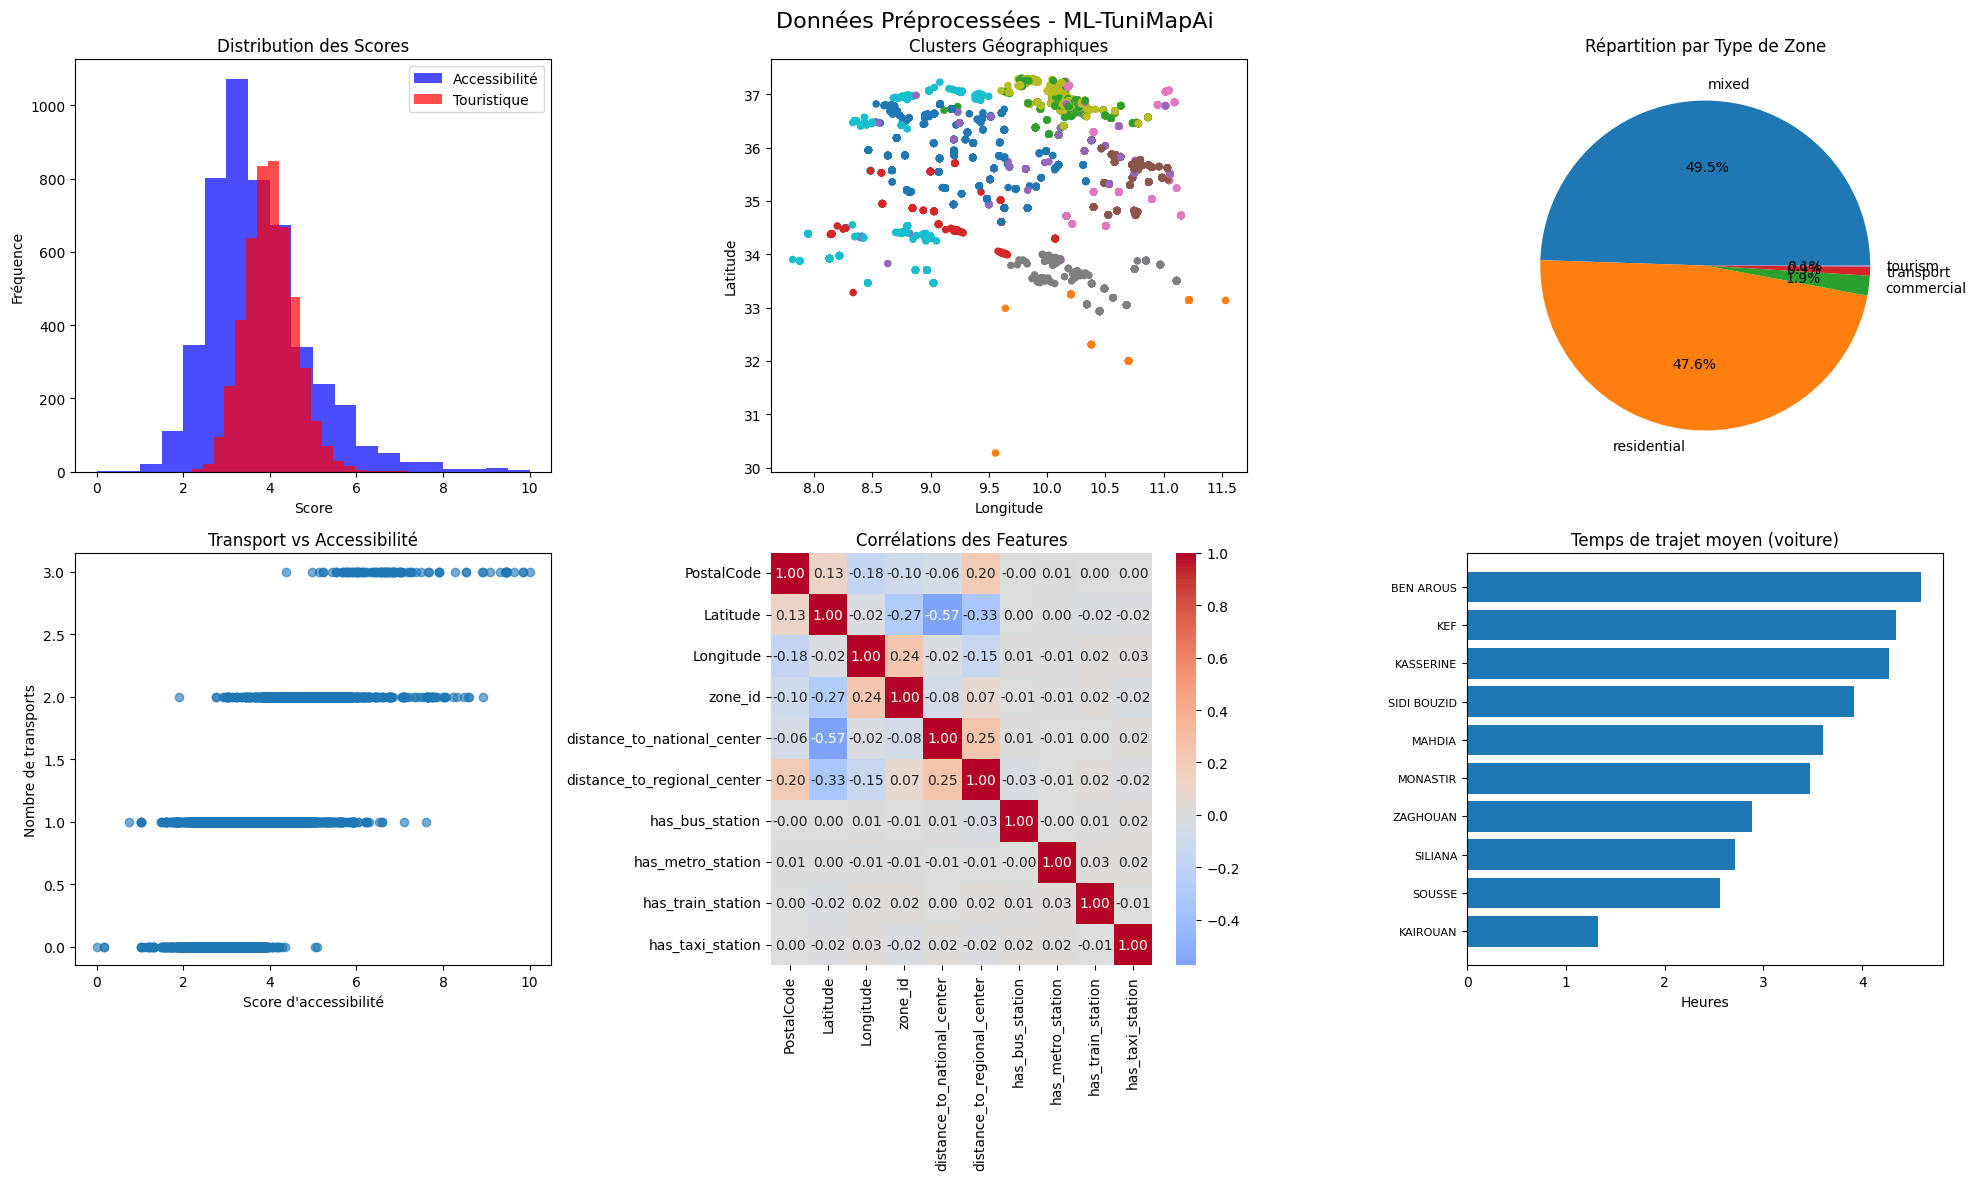

In [15]:
# 13. VISUALISATION DES DONNÉES PRÉPROCESSÉES
print("\n13. VISUALISATION DES DONNÉES PRÉPROCESSÉES")
print("-" * 60)

# Configuration des graphiques
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Données Préprocessées - ML-TuniMapAi', fontsize=16)

# Graphique 1: Distribution des scores
axes[0,0].hist(delegations_df['accessibility_score'], bins=20, alpha=0.7, label='Accessibilité', color='blue')
axes[0,0].hist(delegations_df['tourism_score'], bins=20, alpha=0.7, label='Touristique', color='red')
axes[0,0].set_title('Distribution des Scores')
axes[0,0].set_xlabel('Score')
axes[0,0].set_ylabel('Fréquence')
axes[0,0].legend()

# Graphique 2: Clusters géographiques
scatter = axes[0,1].scatter(delegations_df['Longitude'], delegations_df['Latitude'], 
                           c=delegations_df['cluster_id'], cmap='tab10', s=20)
axes[0,1].set_title('Clusters Géographiques')
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')

# Graphique 3: Types de zones
zone_counts = delegations_df['zone_type'].value_counts()
axes[0,2].pie(zone_counts.values, labels=zone_counts.index, autopct='%1.1f%%')
axes[0,2].set_title('Répartition par Type de Zone')

# Graphique 4: Transport vs Accessibilité
axes[1,0].scatter(delegations_df['accessibility_score'], 
                 delegations_df['has_bus_station'] + delegations_df['has_metro_station'] + 
                 delegations_df['has_train_station'], alpha=0.6)
axes[1,0].set_title('Transport vs Accessibilité')
axes[1,0].set_xlabel('Score d\'accessibilité')
axes[1,0].set_ylabel('Nombre de transports')

# Graphique 5: Heatmap des corrélations
numeric_columns = delegations_df.select_dtypes(include=[np.number]).columns
correlation_matrix = delegations_df[numeric_columns].corr()
top_corr = correlation_matrix.iloc[:10, :10]  # Top 10x10 pour la lisibilité
sns.heatmap(top_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1], fmt='.2f')
axes[1,1].set_title('Corrélations des Features')

# Graphique 6: Temps de déplacement moyen par gouvernorat
avg_times = delegations_df.groupby('Governorate')['time_to_center_car_city_hours'].mean().sort_values()
top_10 = avg_times.head(10)
axes[1,2].barh(range(len(top_10)), top_10.values)
axes[1,2].set_yticks(range(len(top_10)))
axes[1,2].set_yticklabels(top_10.index, fontsize=8)
axes[1,2].set_title('Temps de trajet moyen (voiture)')
axes[1,2].set_xlabel('Heures')

plt.tight_layout()
plt.savefig('../data/visualizations/preprocessing_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# 14. RÉSUMÉ FINAL
print("\n14. RÉSUMÉ DU PRÉPROCESSEMENT")
print("-" * 60)

summary = f"""
RÉSUMÉ DU PRÉPROCESSEMENT - ML-TuniMapAi:

DONNÉES FINALES:
- Points géographiques: {len(delegations_df)}
- Features ML total: {len(ml_features)}
- Gouvernorats couverts: {delegations_df['Governorate'].nunique()}
- Types de zones: {delegations_df['zone_type'].nunique()}

FEATURES CRÉÉES:
✓ Données géographiques (coordonnées, distances)
✓ Classification des zones ({len(delegations_df['zone_type'].unique())} types)
✓ Infrastructure de transport (4 modes)
✓ Scores d'accessibilité et touristique
✓ Clustering géographique ({optimal_k} clusters)
✓ Temps de déplacement estimés (8 modes)
✓ Encodage des variables catégorielles

STATISTIQUES CLÉS:
- Score d'accessibilité moyen: {delegations_df['accessibility_score'].mean():.2f}/10
- Score touristique moyen: {delegations_df['tourism_score'].mean():.2f}/10
- Zones avec transport public: {delegations_df['has_bus_station'].sum()} ({(delegations_df['has_bus_station'].mean()*100):.1f}%)
- Temps moyen au centre (voiture): {delegations_df['time_to_center_car_city_hours'].mean():.1f}h

FICHIERS GÉNÉRÉS:
✓ tunisia_delegations_processed.csv (dataset complet)
✓ tunisia_ml_features.csv (features pour ML)
✓ label_encoders.pkl (encodeurs)
✓ dataset_statistics.csv (statistiques)
✓ preprocessing_summary.png (visualisations)

PROCHAINES ÉTAPES:
1. Construction de la matrice de temps de trajet complète
2. Intégration des données OSM pour les routes réelles  
3. Entraînement des modèles de prédiction ML
4. Développement de l'optimisation des routes touristiques
5. Interface Streamlit interactive
"""

print(summary)

# Sauvegarde du résumé
with open('../data/processed/preprocessing_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✓ Préprocessement terminé! Prêt pour la construction de la matrice de temps de trajet.")
print("✓ Résumé sauvegardé dans 'preprocessing_summary.txt'")


14. RÉSUMÉ DU PRÉPROCESSEMENT
------------------------------------------------------------

RÉSUMÉ DU PRÉPROCESSEMENT - ML-TuniMapAi:

DONNÉES FINALES:
- Points géographiques: 4788
- Features ML total: 25
- Gouvernorats couverts: 24
- Types de zones: 5

FEATURES CRÉÉES:
✓ Données géographiques (coordonnées, distances)
✓ Classification des zones (5 types)
✓ Infrastructure de transport (4 modes)
✓ Scores d'accessibilité et touristique
✓ Clustering géographique (12 clusters)
✓ Temps de déplacement estimés (8 modes)
✓ Encodage des variables catégorielles

STATISTIQUES CLÉS:
- Score d'accessibilité moyen: 3.73/10
- Score touristique moyen: 4.02/10
- Zones avec transport public: 3150 (65.8%)
- Temps moyen au centre (voiture): 5.3h

FICHIERS GÉNÉRÉS:
✓ tunisia_delegations_processed.csv (dataset complet)
✓ tunisia_ml_features.csv (features pour ML)
✓ label_encoders.pkl (encodeurs)
✓ dataset_statistics.csv (statistiques)
✓ preprocessing_summary.png (visualisations)

PROCHAINES ÉTAPES:
1. Const